In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score

In [3]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==========================================================
# Procesamiento del dataset de imágenes
# ==========================================================

# Ruta de la carpeta con imágenes
dataset_folder = '/content/drive/MyDrive/datasets/mydatasetsia/celulas_DS'

# Lista para almacenar las imágenes procesadas
images = []

# Iterar sobre cada archivo de imagen
for image_name in os.listdir(dataset_folder):
    image_path = os.path.join(dataset_folder, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Escala de grises
    if image is not None:
        image = cv2.resize(image, (64, 64))  # Redimensionar a 64x64
        images.append(image.flatten())  # Aplanar la imagen

# Convertir a array de numpy y normalizar
images_array = np.array(images)
scaler = StandardScaler()
images_normalized = scaler.fit_transform(images_array)

# Guardar como CSV
csv_path = '/content/drive/MyDrive/datasets/mydatasetsia/ds_celulas_procesadas.csv'
pd.DataFrame(images_normalized).to_csv(csv_path, index=False)
print(f"Dataset procesado y guardado en {csv_path}")

Dataset procesado y guardado en /content/drive/MyDrive/datasets/mydatasetsia/ds_celulas_procesadas.csv


In [36]:
# ==========================================================
# Cargar el CSV procesado y explorar datos
# ==========================================================

csv_path = '/content/drive/MyDrive/datasets/mydatasetsia/ds_celulas_procesadas.csv'

data = pd.read_csv(csv_path)

# Dimensiones y primeras filas
print(f"Dimensiones del dataset: {data.shape}")
print(data.head())

Dimensiones del dataset: (5571, 4096)
          0         1         2         3         4         5         6  \
0 -0.791291 -0.629035 -0.418574 -0.133095  0.454483  0.767996  0.721355   
1 -0.830873 -0.984334 -0.969165 -0.911628 -0.245987  0.574405  0.528203   
2 -1.305852  0.831639  0.839922  0.762217  0.765803  0.845432  0.798615   
3  0.791973  0.831639  0.839922  0.762217  0.065333 -1.051755 -1.210158   
4  0.712810  0.713206  0.525298  0.295098  0.065333 -0.045084 -0.089881   

          7         8         9  ...      4086      4087      4088      4089  \
0  0.803741  0.766721  0.808681  ...  0.762729  0.803764  0.839784  0.799726   
1  0.493360  0.495499  0.495964  ... -1.688644 -1.601532 -1.395272 -1.193206   
2  0.764944  0.805467  0.808681  ... -1.571912 -1.329966 -1.125524 -1.193206   
3 -1.174941 -1.248073 -0.637637  ... -1.221716 -1.058401 -1.086989 -1.039903   
4 -0.088606  0.030546  0.261426  ...  0.762729  0.687379  0.338823 -0.043437   

       4090      4091      409

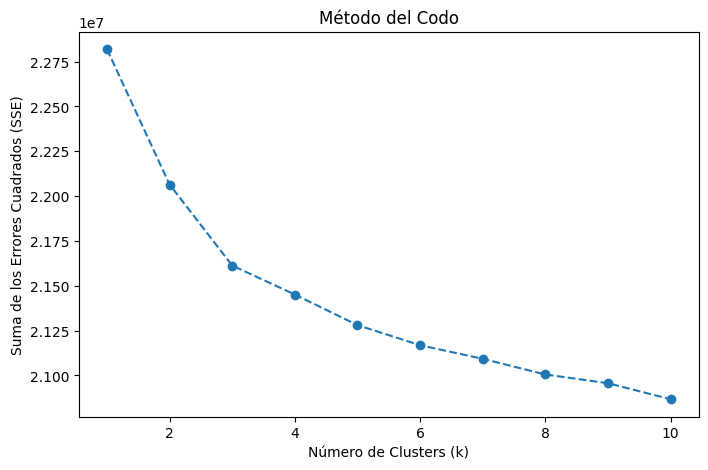

In [37]:
# ==========================================================
# Determinar el número óptimo de clusters
# ==========================================================
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Método del codo
sse = []
range_k = range(1, 11)
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_k, sse, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de los Errores Cuadrados (SSE)')
plt.title('Método del Codo')
plt.show()


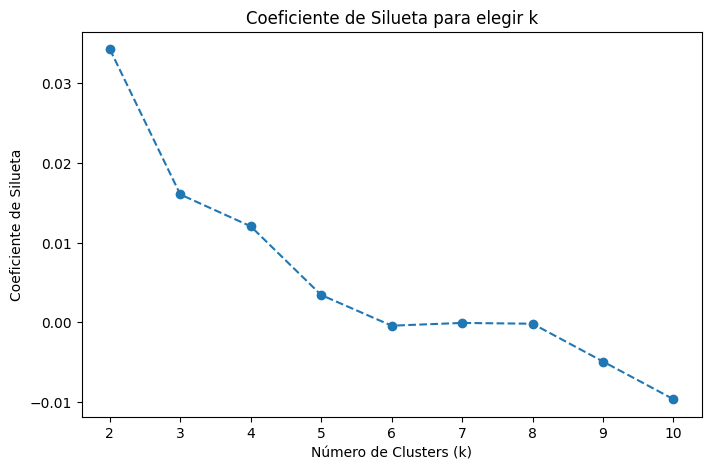

In [38]:
# Coeficiente de Silueta
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para elegir k')
plt.show()

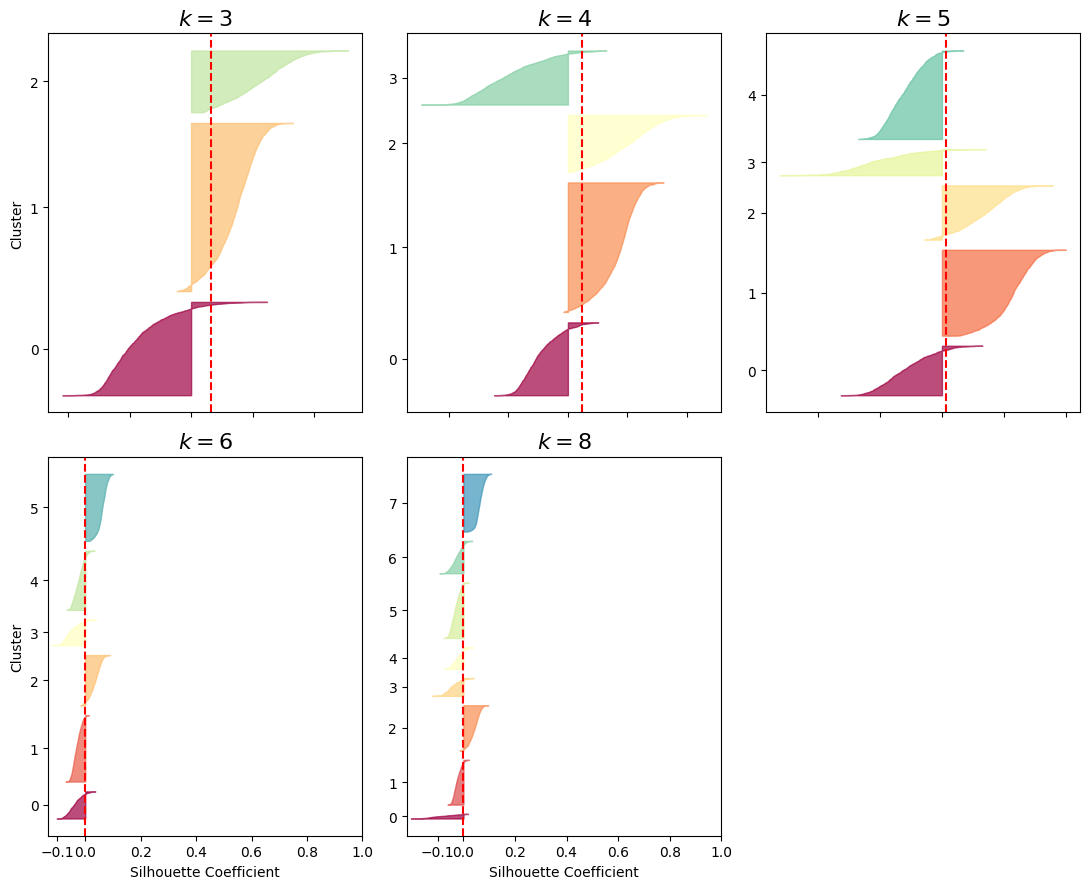

In [39]:
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Definir el rango de k que quieres evaluar
range_k = [3, 4, 5, 6, 8]

# Crear un diccionario para almacenar los modelos KMeans
kmeans_per_k = {}

# Ajustar KMeans para cada valor de k en el rango
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    kmeans_per_k[k] = kmeans

plt.figure(figsize=(11, 9))

for idx, k in enumerate(range_k):
    plt.subplot(2, 3, idx + 1)  # Cambiamos a un layout de 2 filas y 3 columnas

    y_pred = kmeans_per_k[k].labels_
    silhouette_coefficients = silhouette_samples(data, y_pred)

    padding = len(data) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if idx % 3 == 0:
        plt.ylabel("Cluster")

    if idx >= 3:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    # Definimos silhouette_scores según tu propio método
    silhouette_score_value = silhouette_score(data, y_pred)
    plt.axvline(x=silhouette_score_value, color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.tight_layout()
plt.show()


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
datas = pca.fit_transform(data)


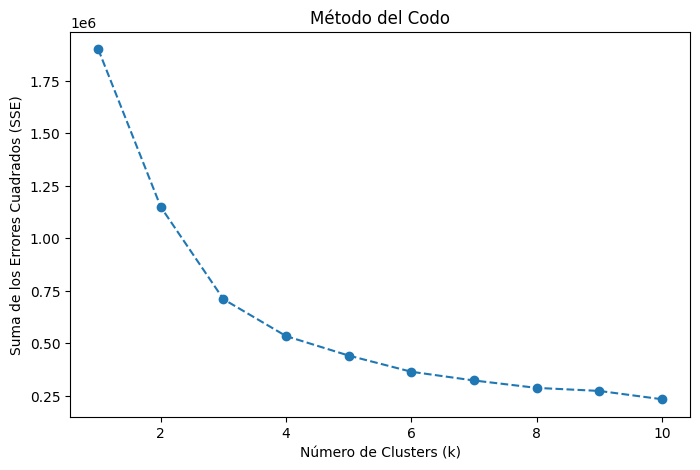

In [ ]:
# ==========================================================
# Determinar el número óptimo de clusters
# ==========================================================
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Método del codo
sse = []
range_k = range(1, 11)
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(datas)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_k, sse, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de los Errores Cuadrados (SSE)')
plt.title('Método del Codo')
plt.show()


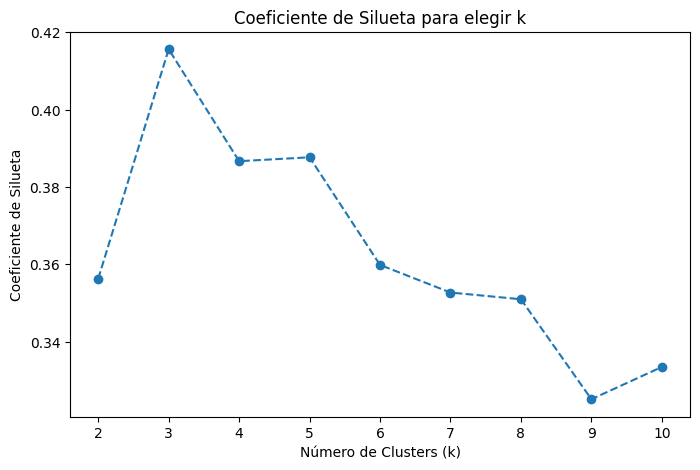

In [ ]:
# Coeficiente de Silueta
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(datas)
    silhouette_scores.append(silhouette_score(data, labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para elegir k')
plt.show()

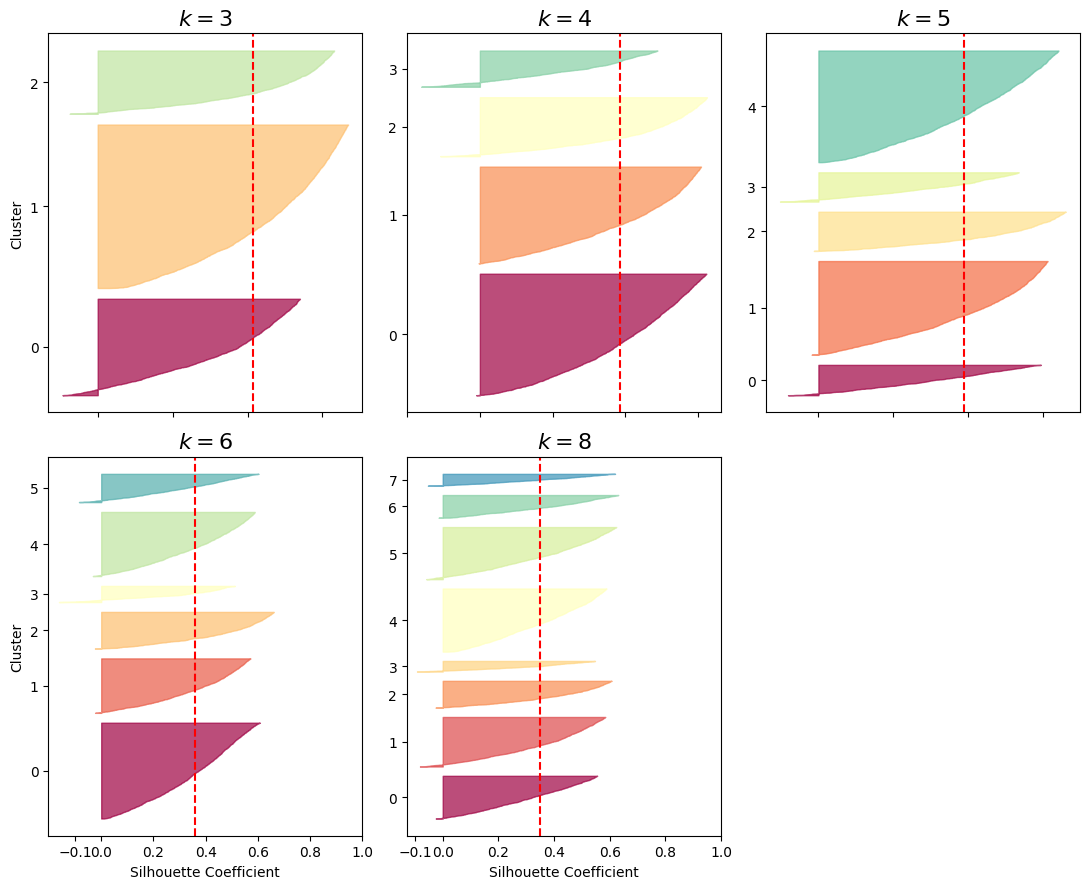

In [26]:
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Definir el rango de k que quieres evaluar
range_k = [3, 4, 5, 6, 8]

# Crear un diccionario para almacenar los modelos KMeans
kmeans_per_k = {}

# Ajustar KMeans para cada valor de k en el rango
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(datas)
    kmeans_per_k[k] = kmeans

plt.figure(figsize=(11, 9))

for idx, k in enumerate(range_k):
    plt.subplot(2, 3, idx + 1)  # Cambiamos a un layout de 2 filas y 3 columnas

    y_pred = kmeans_per_k[k].labels_
    silhouette_coefficients = silhouette_samples(datas, y_pred)

    padding = len(datas) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if idx % 3 == 0:
        plt.ylabel("Cluster")

    if idx >= 3:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    # Definimos silhouette_scores según tu propio método
    silhouette_score_value = silhouette_score(datas, y_pred)
    plt.axvline(x=silhouette_score_value, color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.tight_layout()
plt.show()


In [40]:
# ==========================================================
# Dividir el dataset en entrenamiento y pruebas
# ==========================================================
# Dividir datos en entrenamiento (80%) y pruebas (20%)
train_data, test_data = train_test_split(datas, test_size=0.2, random_state=42)

print(f"Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f"Dimensiones del conjunto de pruebas: {test_data.shape}")

Dimensiones del conjunto de entrenamiento: (4456, 2)
Dimensiones del conjunto de pruebas: (1115, 2)


In [41]:
# Importar las bibliotecas necesarias
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt

# Entrenamiento básico de K-Means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(datas)  # datas debe ser un subconjunto o preprocesamiento de ds_celular_procesadas

# Mostrar los centroides generados
print("Centroides de K-Means:")
print(kmeans.cluster_centers_)

Centroides de K-Means:
[[-16.67101861   3.38282852]
 [  3.24073957  -7.31909349]
 [ 17.20801686  13.65346036]]


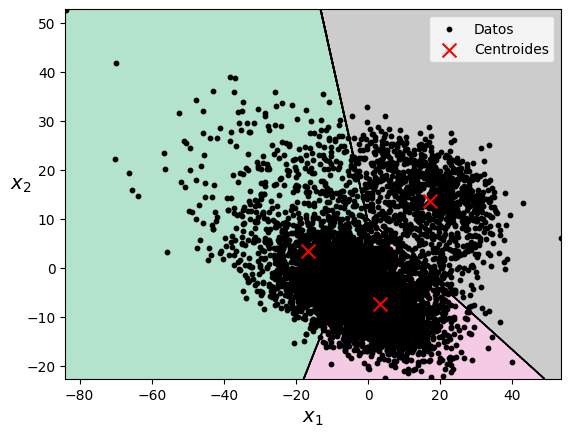

In [17]:
# Visualización de fronteras de decisión para K-Means
def plot_decision_boundaries(clusterer, datas, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    # Calcular límites del gráfico
    mins = datas.min(axis=0) - 0.1
    maxs = datas.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Graficar fronteras y clusters
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')

    # Graficar datos originales
    plt.scatter(datas[:, 0], datas[:, 1], c="k", s=10, label="Datos")

    # Opcional: graficar centroides
    if show_centroids:
        plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                    c="red", marker="x", s=100, label="Centroides")

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

    plt.legend()
    plt.show()

plot_decision_boundaries(kmeans, datas)  # Asegúrate de que `datas` sea bidimensional o reduce la dimensionalidad.


In [18]:
# Comparación de diferentes inicializaciones y configuraciones de K-Means
kmeans_iter1 = KMeans(n_clusters=3, init="k-means++", n_init=1, algorithm="elkan", max_iter=3, random_state=1)
kmeans_iter2 = KMeans(n_clusters=3, init="k-means++", n_init=1, algorithm="elkan", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=3, init="k-means++", n_init=1, algorithm="elkan", max_iter=3, random_state=1)

# Ajustar modelos a los datos
kmeans_iter1.fit(datas)
kmeans_iter2.fit(datas)
kmeans_iter3.fit(datas)



KMeans(algorithm='elkan', max_iter=3, n_clusters=3, n_init=1, random_state=1)

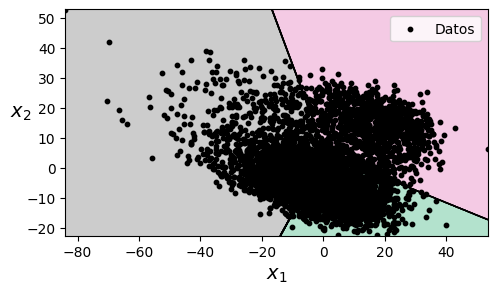

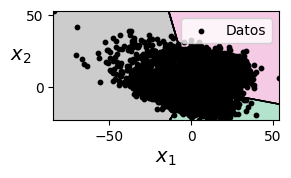

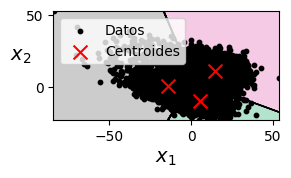

In [25]:
# Visualización de las iteraciones
plt.figure(figsize=(12, 10))

plt.subplot(321)
plot_decision_boundaries(kmeans_iter1, datas, show_centroids=False)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter2, datas, show_centroids=False)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter3, datas)

plt.show()


In [20]:
# ==========================================================
# Función para cargar un batch de datos desde train_data
# ==========================================================
def load_next_batch(batch_size, train_data):
    """
    Carga un batch de datos desde el conjunto de entrenamiento `train_data`.

    Args:
        batch_size (int): Tamaño del batch a cargar.
        train_data (pd.DataFrame or np.ndarray): Datos de entrenamiento.

    Returns:
        np.ndarray: Batch de datos listo para MiniBatchKMeans.
    """
    if isinstance(train_data, pd.DataFrame):
        return train_data.sample(batch_size).to_numpy()
    elif isinstance(train_data, np.ndarray):
        indices = np.random.choice(len(train_data), batch_size, replace=False)
        return train_data[indices]
    else:
        raise ValueError("train_data debe ser un DataFrame de pandas o un array de numpy.")


In [42]:
# ==========================================================
# Entrenamiento con MiniBatchKMeans
# ==========================================================
k = 3  # Número de clusters
n_init = 10  # Inicializaciones
n_iterations = 100
batch_size = 100
init_size = 500
evaluate_on_last_n_iters = 10

best_kmeans = None  # Almacena el mejor modelo
optimal_k = 3  # Valor óptimo determinado por análisis de codo/silueta

for init in range(n_init):
    # Inicializa MiniBatchKMeans
    minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, init_size=init_size, random_state=42)

    # Selección de datos iniciales para inicialización
    X_init = load_next_batch(init_size, train_data)
    minibatch_kmeans.partial_fit(X_init)

    # Entrenamiento iterativo con batches
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size, train_data)
        minibatch_kmeans.partial_fit(X_batch)

        # Evaluación de las últimas iteraciones
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    # Selección del mejor modelo basado en inercia acumulada
    if (best_kmeans is None or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

# Resultados

print("MiniBatchKMeans finalizado con los mejores parámetros.")
print(f"Inercia del mejor modelo: {best_kmeans.inertia_}")

MiniBatchKMeans finalizado con los mejores parámetros.
Inercia del mejor modelo: 9207.943364338742


In [53]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(datas)
y_pred

array([2, 2, 2, ..., 0, 1, 1], dtype=int32)

In [52]:
# ==========================================================
# Evaluación del modelo en datos de prueba
# ==========================================================
# Etiquetas predichas para el conjunto de prueba
test_labels = best_kmeans.predict(test_data)

# Métrica de evaluación: Coeficiente de silueta
silhouette_avg = silhouette_score(test_data, test_labels)
print(f"Coeficiente de Silueta en datos de prueba: {silhouette_avg:.4f}")

Coeficiente de Silueta en datos de prueba: 0.4107


In [45]:
# ==========================================================
# Comparación con umbral del 80% (coeficiente de silueta > 0.8)
# ==========================================================

if silhouette_avg > 0.8:
    print(f"Coeficiente de Silueta en datos de prueba: {silhouette_avg:.4f} (Excelente desempeño)")
else:
    print(f"Coeficiente de Silueta en datos de prueba: {silhouette_avg:.4f} (Desempeño mejorable)")


Coeficiente de Silueta en datos de prueba: 0.4107 (Desempeño mejorable)


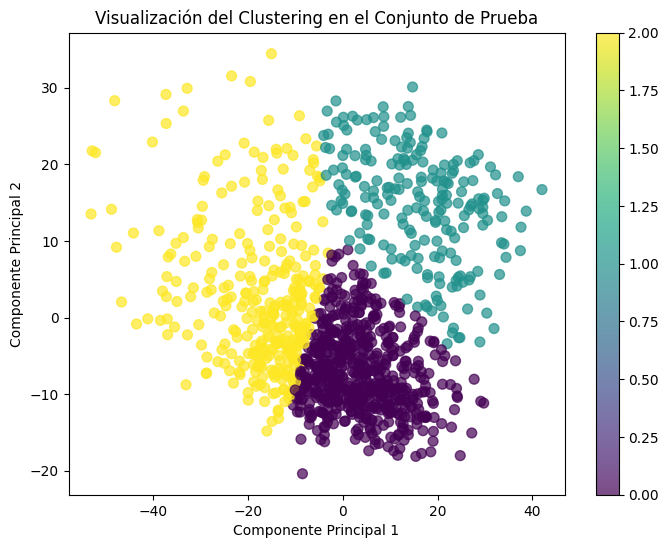

In [46]:
# ==========================================================
# Visualización opcional de resultados
# ==========================================================
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducir dimensiones para visualización
pca = PCA(n_components=2)
test_data_2d = pca.fit_transform(test_data)

plt.figure(figsize=(8, 6))
plt.scatter(test_data_2d[:, 0], test_data_2d[:, 1], c=test_labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title("Visualización del Clustering en el Conjunto de Prueba")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

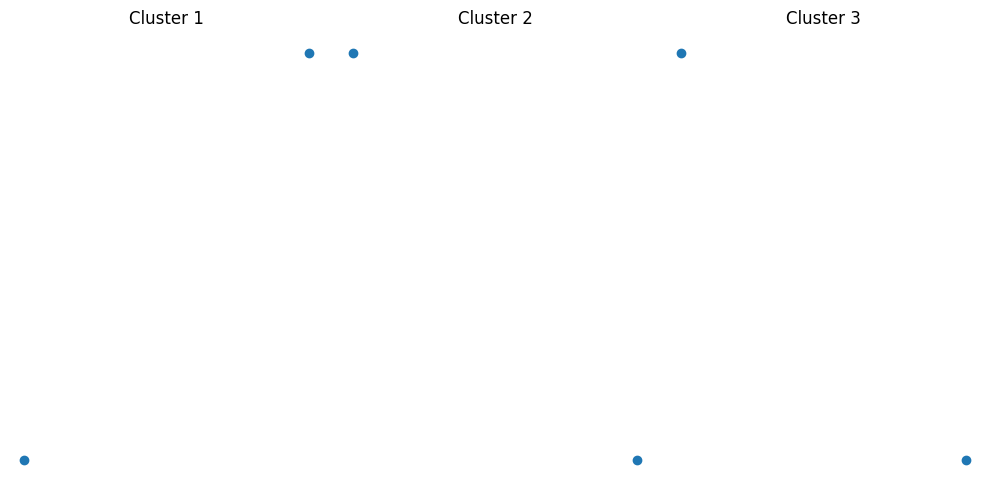

Precisión en los datos de entrenamiento: 0.98


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [75]:
# Asumimos que los datos ya han sido normalizados previamente
X_train = datas  # Usar los datos procesados
y_train = np.random.randint(0, 2, size=len(X_train))  # Generar etiquetas aleatorias para probar

# Inicializar el modelo KMeans
k = 3  # Número de clusters (puedes ajustarlo según lo que obtuviste del codo o coeficiente de silueta)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

# Obtener las representaciones de los clusters (centros de los clusters)
X_representative_digits = kmeans.cluster_centers_

# Mostrar representaciones de los clusters
plt.figure(figsize=(10, 5))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(1, k, index + 1)
    plt.plot(X_representative_digit, 'o')  # Graficar los centroides como puntos (dimensionalidad real)
    plt.title(f"Cluster {index + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Entrenar un modelo de regresión logística usando los datos originales y las etiquetas de K-Means
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)

# Usar los datos originales como X y las etiquetas asignadas por K-Means como y
log_reg.fit(X_train, kmeans.labels_)

# Precisión en los datos de prueba
accuracy = log_reg.score(X_train, kmeans.labels_)
print(f"Precisión en los datos de entrenamiento: {accuracy:.2f}")

DBSCAN

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV procesado de células
data = pd.read_csv('/content/drive/MyDrive/datasets/mydatasetsia/ds_celulas_procesadas.csv')

# Asegúrate de que los datos estén correctamente procesados
X = data.values  # Usar todas las columnas para clustering (excepto las etiquetas si las tienes)

# Configuración de DBSCAN
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

# Verifica si se encontraron puntos nucleares
if len(dbscan2.core_sample_indices_) > 0:
    print("Puntos nucleares encontrados.")
    # Clasificación usando KNN con componentes de DBSCAN
    knn = KNeighborsClassifier(n_neighbors=50)
    knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

    # Ejemplo de predicción con nuevos datos
    X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
    print("Predicciones de KNN:", knn.predict(X_new))
    print("Probabilidades de KNN:", knn.predict_proba(X_new))

    # Visualización de las fronteras de decisión de KNN
    plt.figure(figsize=(6, 3))
    # Necesitas definir la función plot_decision_boundaries para la visualización
    # Si no tienes esta función, debes implementarla o eliminarla si no es necesaria
    plot_decision_boundaries(knn, X, show_centroids=False)

    plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
    plt.show()
else:
    print("No se encontraron puntos nucleares. Ajusta los parámetros de DBSCAN.")


No se encontraron puntos nucleares. Ajusta los parámetros de DBSCAN.
